####                                           Random deep neural networks are biased towards simple functions
In this paper the authors  prove that the binary classifiers of bit strings generated by random wide deep
neural networks with ReLU activation function are biased towards simple functions.
This is captured by the following two properties. 

Theorem 1 For any given input bit string, the average Hamming distance of the closest input bit string with a
different classification is at least sqrt(n/(2π ln n)), where n is the length of the string.

Theorem 2 If the bits of the initial string are flipped randomly, the average number of flips required to change the classification grows linearly with n.

Q1.Building random neural classifiers The paper uses n-n-n-1 networks with ReLU
activation functions for the hidden layers and the identity function as the activation
function of the output neuron, more details given in Sec. 4.4. of the paper. Prepare the
necessary code to create, initialize and execute instances of such networks suitable for
collecting statistics about the mappings


Ans. All networks consist of two fully connected hidden layers,
each with n neurons (equal to number of input neurons) and activation function set to the commonly
used Rectified Linear Unit (ReLU). All networks contain a single output neuron with no activation
function. Simulations were run using the python package Keras with a
backend of TensorFlow




In [3]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model
from keras import callbacks
from keras.models import load_model
import numpy as np
import itertools
# from lempel_ziv_complexity import lempel_ziv_complexity
from keras.initializers import glorot_uniform
from keras.initializers import VarianceScaling
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy.stats import kstat
import pandas as pd
from math import ceil
from random import shuffle
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import os
import pickle
import pandas as pd

Using TensorFlow backend.


In [33]:
def create_net(n_features = 7,  
    hidden_shape = [100,100], 
    n_outputs = 1,
    A_type = 'tanh', #'relu'
    out_A_type = None,
    init_type = 'glorot_uniform',
    b_init_type = 'zeros',
    include_bias = False,
    var_scale_val = 2.0):

    model = Sequential()

    net_shape = [n_features]+hidden_shape

    # variance scaling where weights are set based on number of fan_in neurons
    if init_type == 'VarianceScaling':
        init_type = VarianceScaling(var_scale_val,
            mode = 'fan_in', distribution = 'normal')

    # adding hidden layers
    for layer_i in range(len(net_shape)-1):
        model.add(Dense(net_shape[layer_i+1],
            input_shape = (net_shape[layer_i],),
            activation = A_type,
            use_bias = include_bias,
            kernel_initializer=init_type,
            bias_initializer=b_init_type))

    # adding output layer
    model.add(Dense(n_outputs,
        activation = out_A_type,
        use_bias = include_bias))

    return model

Q2. Experiment 1: Hamming distance (Sec. 4.1). Replicate experiment 1 for determining the average closest Hamming distance to the nearest bit string b(a) of a random
binary input a that has a different classification, i.e., find
h(n) = Ea,θ
[min
b
{h(a − b)|φn(a, θ) · φn(b, θ) < 0}]
i
Reproduce Fig.1 in the paper (averaging about 250 neural networks to save compute
time). I.e., generate 250 random networks (each with new weights θ ), for each random
network a random input a, and determine for this pairing the nearest input b(a) for
which φn(a, θ)· φn(b(a), θ) < 0. Use the greedy search algorithm described in 4.1 in the
paper and condition h(n) on the value of |φn(a)| (refer to Sec. 4.1 for an explanation)
to reproduce Fig.1 (b).
Then repeat the experiment for a tanh nonlinearity and compare results.


### Theorem1
For n >>1, where n is the length of the string, for any given input bit string
the average Hamming distance of the closest bit string with a different classification is at
least sqrt(n/(2π ln n)), where the Hamming distance between two bit strings is
the number of different bits.

In [3]:
### for eg if an input list of [1,1,1,1] is given it will create a list of list 

# For 3 iterations
# Iter 1
#    array([[-1,  1,  1,  1,  1],
#        [ 1, -1,  1,  1,  1],
#        [ 1,  1, -1,  1,  1],
#        [ 1,  1,  1, -1,  1],
#        [ 1,  1,  1,  1, -1]]), 
# Iter 2
#       array([[-1, -1,  1,  1,  1],
#        [-1,  1, -1,  1,  1],
#        [-1,  1,  1, -1,  1],
#        [-1,  1,  1,  1, -1],
#        [ 1, -1, -1,  1,  1],
#        [ 1, -1,  1, -1,  1],
#        [ 1, -1,  1,  1, -1],
#        [ 1,  1, -1, -1,  1],
#        [ 1,  1, -1,  1, -1],
#        [ 1,  1,  1, -1, -1]]), 
# Iter 3 
#  array([[-1, -1, -1,  1,  1],
#        [-1, -1,  1, -1,  1],
#        [-1, -1,  1,  1, -1],
#        [-1,  1, -1, -1,  1],
#        [-1,  1, -1,  1, -1],
#        [-1,  1,  1, -1, -1],
#        [ 1, -1, -1, -1,  1],
#        [ 1, -1, -1,  1, -1],
#        [ 1, -1,  1, -1, -1],
#        [ 1,  1, -1, -1, -1]])]

def hamming_list(vec, dist, a = -1, b = 1):
    
    # list of lists need to be appended correctly
    def append_correctly(item1, item2, item3):
        if isinstance(item3, list):
            if any(isinstance(el, list) for el in item3):
                for i in item3:
                    outputlist.append(item1+item2+i)
            else:
                outputlist.append(item1+item2+item3)
        else:
            outputlist.append(item1+item2+[item3])

    # recursively create hamming list
    if dist == 0:
        return vec
    else:
        outputlist = list()
        for item in range(len(vec)):
            if len(vec[item:]) > dist - 1:
                if vec[item] == a:
                    rest = hamming_list(list(vec[item+1:]), dist - 1)
                    if isinstance(rest, list):
                        outputlist.append(vec[:item]+[b]+rest)
                    else:
                        outputlist.append(vec[:item]+[b]+[rest])
                else:
                    rest = hamming_list(list(vec[item + 1:]), dist - 1)
                    append_correctly(vec[:item],[a],rest)
    return outputlist


X_val_arr = []
vec = [1]*100     # input number of features here for hamming list to be created

for i in range(3):
    X_val_arr.append(np.asarray(hamming_list(vec, i+1)))
    print(i)

    with open('pickles/hamming_list_100_3.pickle', 'wb') as handle:
        pickle.dump(X_val_arr, handle)

Hamming distances to the closest bit string with a different classification were calculated for randomly generated neural networks with parameters sampled from normal distributions. This distance was calculated using a greedy
search algorithm. 

In this algorithm, the search for a differently classified bit string progressed in steps, where in each step, the most significant bit was flipped. This bit corresponded to the one that produced the largest change towards zero in the value of the output neuron when flipped.

In [4]:
# run search to find any bit string with different classification
# optional to set a batch_size
def batch_check(batch_size = None):
    if batch_size is None:
        Y = model.predict(X)
        print('checking')
        Y_0 = Y > out_thresh
        return np.any((not Y_base_0) == Y_0)
    else:
        n_batches = ceil(X.shape[0] / batch_size)
        for i in range(n_batches):
            if i == (n_batches - 1):
                Y = model.predict(X[batch_size*i:])
            else:
                Y = model.predict(X[batch_size*i:batch_size*(i+1)])

            Y_0 = Y > out_thresh
            print('checking '+str(i))
            if np.any((not Y_base_0) == Y_0):
                return True
        return False

In [18]:
name = 'ham_validation_256_d4_try3_relu'        # name of simulation - used to save csv file
n_models = 250                                  # number of models to create and perform search on
bit_vals = [-1, 1]                              # values of bits for input neurons

init = 'VarianceScaling'                        # initialization for weights - see utils
out_activation = 'linear'                       # type of activation in final neuron
out_thresh = 0.                                 # threshold to determine binary classification
n_feat = 256                                    # number of features in model
hidden_layers = [100,100]                       # size of hidden layers

clear_sess_n = 1                                # how many loops to run before clearing keras session
save_n = 10                                     # how many loops to run before saving outputs to csv

# initializing lists to store outputs of calculations
num_vals = range(n_models)
name_vals = [name]*(n_models)
num_feat_vals = []
ham_dist_vals = []
phi_vals = []
n_models_vals = [n_models]*(n_models)

# starting point of search
X_base = np.ones(n_feat)

# get bit strings at various hamming distances in a list
# run create_hamming_pickle code to create this pickle
with open('pickles/hamming_list_100_3.pickle', 'rb') as handle:
    X_val_arr = pickle.load(handle)

X_base = X_base.reshape(-1, len(X_base))


In [19]:
start = time.time()

for mod_i in range(n_models):

    # show time taken to perform clear_sess_n loops
    # also clean up memory and clear current keras session
    if mod_i%clear_sess_n == 0:
        print(mod_i)
        print(time.time()-start)
        start = time.time()
        utils.clear_session()
        gc.collect()

    # create new network with randomized initializations
    model = utils.create_net(out_A_type = out_activation, 
        init_type = init,
        n_features = n_feat, 
        hidden_shape = hidden_layers)

    # predict starting point of search and determine classification
    Y_base = model.predict(X_base)
    print(Y_base)
    Y_base_0 = Y_base > out_thresh

    # run search at progressively increasing distance until point with different classification found
    dist_val = 1
    for X in X_val_arr:
        batch_size = None
        if dist_val == len(X_val_arr):
            batch_size = 10**5

        if batch_check(batch_size):
            break
        dist_val+=1

    # print(dist_val)

    # appending results of calculations to output to csv later
    ham_dist_vals.append(dist_val)
    num_feat_vals.append(n_feat)
    phi_vals.append(Y_base[0][0])

    if mod_i%save_n == 0:
        # placing data in dictionary and saving to csv using pandas
        pd_cols = {'Name': name_vals[:(mod_i+1)],
            'Model_Num': num_vals[:(mod_i+1)],
            'N_models': n_models_vals[:(mod_i+1)],
            'Num_features': num_feat_vals,
            'Distance_Num': ham_dist_vals,
            'Phi_Val': phi_vals
            }
        df = pd.DataFrame(data=pd_cols)
        df.to_csv('../csv_files/'+name+'.csv')
        print(df)


# placing data in dictionary and saving to csv using pandas
pd_cols = {'Name': name_vals,
    'Model_Num': num_vals,
    'N_models': n_models_vals,
    'Num_features': num_feat_vals,
    'Distance_Num': ham_dist_vals,
    'Phi_Val': phi_vals
    }
df = pd.DataFrame(data=pd_cols)
df.to_csv('csv_files/'+name+'.csv')
print(df)


In [5]:
df = pd.read_csv("csv_files/ham_validation_100_d4_try3relu.csv")

In [6]:
df_1 = df.loc[df['Distance_Num'] == 1]
dphi_1 = np.abs(df_1["Phi_Val"]).mean()

df_2 = df.loc[df['Distance_Num'] == 2]
dphi_2 = np.abs(df_2["Phi_Val"]).mean()

df_3 = df.loc[df['Distance_Num'] == 3]
dphi_3 = np.abs(df_3["Phi_Val"]).mean()

df_4 = df.loc[df['Distance_Num'] == 4]
dphi_4 = np.abs(df_4["Phi_Val"]).mean()

Text(0, 0.5, 'Average Hamming Distance')

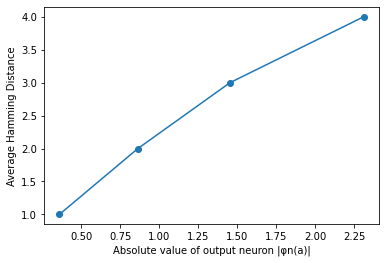

In [8]:
plt.plot([dphi_1,dphi_2,dphi_3,dphi_4],[1,2,3,4],marker='o')
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")

## Tanh

In [9]:
df1 = pd.read_csv("csv_files/ham_validation_100_d4_try3tanh.csv")

df_1 = df1.loc[df1['Distance_Num'] == 1]
dphi_11 = np.abs(df_1["Phi_Val"]).mean()


df_2 = df1.loc[df1['Distance_Num'] == 2]
dphi_21 = np.abs(df_2["Phi_Val"]).mean()


df_3 = df1.loc[df1['Distance_Num'] == 3]
dphi_31 = np.abs(df_3["Phi_Val"]).mean()

df_4 = df1.loc[df1['Distance_Num'] == 4]
dphi_41 = np.abs(df_4["Phi_Val"]).mean()

Text(0, 0.5, 'Average Hamming Distance')

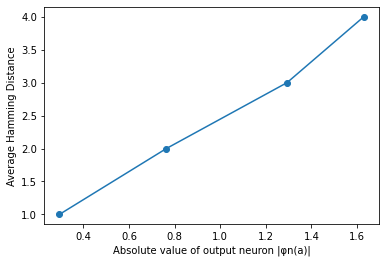

In [10]:
plt.plot([dphi_11,dphi_21,dphi_31,dphi_41],[1,2,3,4],marker='o')
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")

Text(0, 0.5, 'Average Hamming Distance')

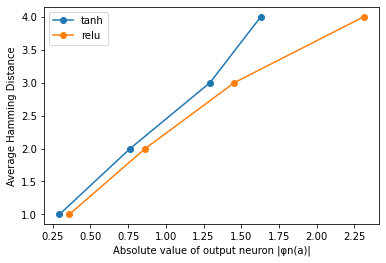

In [11]:
plt.plot([dphi_11,dphi_21,dphi_31,dphi_41],[1,2,3,4],marker='o',label='tanh')
plt.plot([dphi_1,dphi_2,dphi_3,dphi_4],[1,2,3,4],marker='o',label='relu')
plt.legend()
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")

Q3. Depth dependence While Experiment 1 focussed on the scaling w.r.t. input width,
it might also be interesting to consider depth dependence. To this end, focus on a single
input width (e.g. n=2048) and estimate h(n) for deeper networks that “taper out”
to keep compute resources manageable. E.g. consider networks with 2..5 hidden layers
taken from the sequence n-n/2-n/4-n/8-n/16-n/32 with always 1 fully connected output
neuron (go as far as compute power permits, return to ReLU nonlinearity). Since the
theory is depth-independent, all data points should fall onto approximately the same h(n)
value. 
However, given that the Gaussian process (mean field) approximation is made,
what would you expect as the depth of the network increases?


In [15]:
name = 'ham_validation_256_d4_try3_relu'        # name of simulation - used to save csv file
n_models = 250                                  # number of models to create and perform search on
bit_vals = [-1, 1]                              # values of bits for input neurons

init = 'VarianceScaling'                        # initialization for weights - see utils
out_activation = 'linear'                       # type of activation in final neuron
out_thresh = 0.                                 # threshold to determine binary classification
n_feat = 256                                    # number of features in model
hidden_layers = [256,128,64,32,16]              # size of hidden layers

clear_sess_n = 1                                # how many loops to run before clearing keras session
save_n = 10                                     # how many loops to run before saving outputs to csv

# initializing lists to store outputs of calculations
num_vals = range(n_models)
name_vals = [name]*(n_models)
num_feat_vals = []
ham_dist_vals = []
phi_vals = []
n_models_vals = [n_models]*(n_models)

# starting point of search
X_base = np.ones(n_feat)

# get bit strings at various hamming distances in a list
# run create_hamming_pickle code to create this pickle
with open('../pickles/hamming_list_256_3.pickle', 'rb') as handle:
    X_val_arr = pickle.load(handle)

X_base = X_base.reshape(-1, len(X_base))

In [17]:
start = time.time()

for mod_i in range(n_models):

    # show time taken to perform clear_sess_n loops
    # also clean up memory and clear current keras session
    if mod_i%clear_sess_n == 0:
        print(mod_i)
        print(time.time()-start)
        start = time.time()
        utils.clear_session()
        gc.collect()

    # create new network with randomized initializations
    model = utils.create_net(out_A_type = out_activation, 
        init_type = init,
        n_features = n_feat, 
        hidden_shape = hidden_layers)

    # predict starting point of search and determine classification
    Y_base = model.predict(X_base)
    print(Y_base)
    Y_base_0 = Y_base > out_thresh

    # run search at progressively increasing distance until point with different classification found
    dist_val = 1
    for X in X_val_arr:
        batch_size = None
        if dist_val == len(X_val_arr):
            batch_size = 10**5

        if batch_check(batch_size):
            break
        dist_val+=1

    # print(dist_val)

    # appending results of calculations to output to csv later
    ham_dist_vals.append(dist_val)
    num_feat_vals.append(n_feat)
    phi_vals.append(Y_base[0][0])

    if mod_i%save_n == 0:
        # placing data in dictionary and saving to csv using pandas
        pd_cols = {'Name': name_vals[:(mod_i+1)],
            'Model_Num': num_vals[:(mod_i+1)],
            'N_models': n_models_vals[:(mod_i+1)],
            'Num_features': num_feat_vals,
            'Distance_Num': ham_dist_vals,
            'Phi_Val': phi_vals
            }
        df = pd.DataFrame(data=pd_cols)
        df.to_csv('../csv_files/'+name+'.csv')
        print(df)


# placing data in dictionary and saving to csv using pandas
pd_cols = {'Name': name_vals,
    'Model_Num': num_vals,
    'N_models': n_models_vals,
    'Num_features': num_feat_vals,
    'Distance_Num': ham_dist_vals,
    'Phi_Val': phi_vals
    }
df = pd.DataFrame(data=pd_cols)
df.to_csv('../csv_files/'+name+'.csv')
print(df)


In [12]:
df2 = pd.read_csv("csv_files/ham_validation_256_d4_try3_relu.csv")

df_1 = df2.loc[df2['Distance_Num'] == 1]
dphi_12 = np.abs(df_1["Phi_Val"]).mean()

df_2 = df2.loc[df2['Distance_Num'] == 2]
dphi_22 = np.abs(df_2["Phi_Val"]).mean()

df_3 = df2.loc[df2['Distance_Num'] == 3]
dphi_32 = np.abs(df_3["Phi_Val"]).mean()

df_4 = df2.loc[df2['Distance_Num'] == 4]
dphi_42 = np.abs(df_4["Phi_Val"]).mean()

Text(0, 0.5, 'Average Hamming Distance')

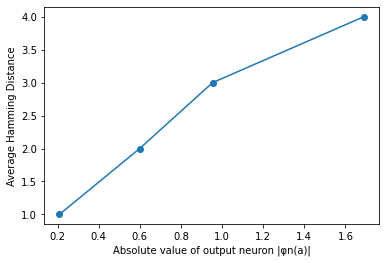

In [13]:
plt.plot([dphi_12,dphi_22,dphi_32,dphi_42],[1,2,3,4],marker='o')
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")

##  All the 3 plots

Text(0, 0.5, 'Average Hamming Distance')

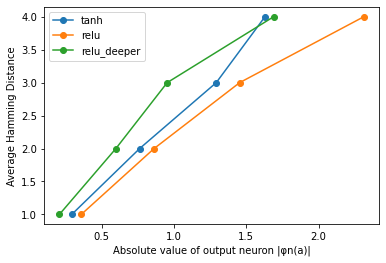

In [14]:
plt.plot([dphi_11,dphi_21,dphi_31,dphi_41],[1,2,3,4],marker='o',label='tanh')
plt.plot([dphi_1,dphi_2,dphi_3,dphi_4],[1,2,3,4],marker='o',label='relu')
plt.plot([dphi_12,dphi_22,dphi_32,dphi_42],[1,2,3,4],marker='o',label='relu_deeper')
plt.legend()
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")

Q4. Random bit flips. Redo the experiment from Sec. 4.2 to confirm the linear scaling
law of Theorem 2, but use tanh instead of ReLU (again, using 250 networks might be
sufficient).

(Theorem 2) If the bits of the initial string are randomly flipped, the average number of
bit flips required to change the classification grows linearly with n 

In [3]:
def direct_search_X(n_X = 100, bit_vals = [-1,1]):
    a = np.ones((n_X, n_X))
    a = np.tril(a)
    if bit_vals[0] != 0:
        a[a==1] = bit_vals[0]
        a[a==0] = bit_vals[1]
    else: 
        a[a==1] = max(bit_vals)+1
        a[a==0] = min(bit_vals)-1
        a[a==max(bit_vals)+1] = bit_vals[0]
        a[a==min(bit_vals)-1] = bit_vals[1]
    return a

In [35]:
def batch_check(model, X, Y_base_0, batch_size = None, out_thresh = 0, n_features = 1000):
    if batch_size is None: 
        # if no batch size given, then just predict on whole dataset
        Y = model.predict(X)

        # check if any differently classified
        if np.any((not Y_base_0) == Y):
            return np.where((not Y_base_0) == Y)[0][0]+1
        else:
            return n_feature # if no differently classified, then return the number of features (num bits to flip)

    else:
        # running check in batches
        n_batches = ceil(n_features / batch_size)
        for i in range(n_batches):
            if i == (n_batches - 1):
                Y = model.predict(X[batch_size*i:])
                Y_0 = Y > out_thresh
            else:
                Y = model.predict(X[batch_size*i:batch_size*(i+1)])
                Y_0 = Y > out_thresh
            if np.any((not Y_base_0) == Y_0):
                return batch_size*i + np.where((not Y_base_0) == Y_0)[0][0]+1
        return n_features


In [36]:
# get starting point of search
# n = 1000
def return_X(id_i, n = 1000):
    a = X_inputs[int(id_i/n)]
    return a

In [37]:
def run_model(id_i):

    X = return_X(id_i) # get starting bit string

    init = 'VarianceScaling' # variance of weights set by number of fan in 
    out_activation = 'linear'# no activation i nfinal neuron
    out_thresh = 0.          # final neuron values above or below threshold to determine classification
    n_feat = X.shape[1]      # number of features 
    hidden_layers = [n_feat, n_feat] # shape of hidden layers


    # creating network
    model = create_net(out_A_type = out_activation, 
        init_type = init,
        n_features = n_feat, 
        hidden_shape = hidden_layers)

    # get classification of starting bit string
    X_base = np.ones(n_feat).reshape(-1,n_feat)
    Y_base = model.predict(X_base)
    Y_base_0 = Y_base > out_thresh

    # run check to see after how many flips we get a different classification
    steps = batch_check(model, X, Y_base_0, 
        batch_size =500,
        out_thresh = out_thresh,
        n_features = n_feat)

    # clear Keras session (remove junk)
    utils.clear_session()
    gc.collect()

    return [steps, Y_base[0][0]]


In [38]:
def save_results(results):
    results_out = list(zip(*results))

    pd_cols = {'Name': name_vals[:len(results_out[0])],
        'Model_Num': num_vals[:len(results_out[0])],
        'N_models': n_models_vals[:len(results_out[0])],
        'Num_features': num_feat_vals[:len(results_out[0])],
        'Distance_Num': results_out[0],
        'Phi_Val': results_out[1]
        }

    df = pd.DataFrame(data=pd_cols)
    df.to_csv('csv_files/'+name+'.csv')
    print(df)
    return df

In [39]:
n_models = 250  # number of models to run search on for each feature size
n_feat_arr = [50,100,200,500] # feature sizes to run search on

X_inputs = [] # list containing starting bit strings

num_feat_vals = [] # initializing storage variables for outputs
for n_feat in n_feat_arr:
    num_feat_vals.extend([n_feat]*n_models)
    X_inputs.append(direct_search_X(n_feat))


In [40]:
if __name__ == '__main__':
    name = 'direct_search_50_100_200_500_1'
    bit_vals = [-1, 1]

    num_vals = range(n_models*len(n_feat_arr)) # list cotaining number of features 
    name_vals = [name]*(n_models*len(n_feat_arr)) # list containing name of simulation 
    ham_dist_vals = []   # list containing hamming distances 
    phi_vals = []   # list containing output neuron values 
    n_models_vals = [n_models]*(n_models*len(n_feat_arr)) # list contaning number of models tested 

    # initializing storage variables for outputs
    results_out = [[],[]]
    results = []

    # loop through feature sizes
    for feat_i in range(len(n_feat_arr)):

        # loop through number of models to create for each size
        for i in range(n_models):

            a = run_model(feat_i*n_models+i)
            results.append(a)

            # save results after every 10 iterations
            if i%10 == 0:
                df = save_results(results)

        df = save_results(results)

#### Plot

In [41]:
df2 = pd.read_csv("csv_files/direct_search_50_100_200_500_1.csv")
df_100 = df2.loc[df2['Num_features'] == 50]
dist_val_100 = df_100["Distance_Num"].mean()
df_200 = df2.loc[df2['Num_features'] == 100]
dist_val_200 = df_200["Distance_Num"].mean()
df_500 = df2.loc[df2['Num_features'] == 200]
dist_val_500 = df_500["Distance_Num"].mean()
df_1000 = df2.loc[df2['Num_features'] == 500]
dist_val_1000 = df_1000["Distance_Num"].mean()

Text(0, 0.5, 'Average Hamming Distance')

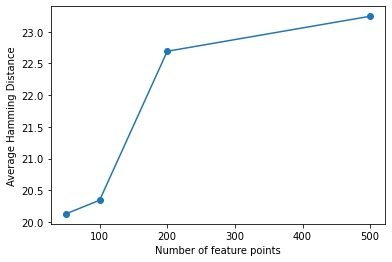

In [42]:
plt.plot([50,100,200,500],[dist_val_100,dist_val_200,dist_val_500,dist_val_1000],marker='o')
plt.xlabel("Number of feature points")
plt.ylabel("Average Hamming Distance")

Q5. Trained neural networks. Redo the experiment for a trained network, as described
in Sec. 4.3, Analysis of MNIST data. However, instead of the MNIST dataset, train a
n-n-n-1 network (with n=1000) to map 1000 randomly chosen binary inputs to +/- 1
to the same number of random targets +/- 1 and calculate the analogues of diagrams
Fig.3 a) and (b).



The theoretical results hold for random, untrained deep neural networks. So the authors raised an interesting question
whether trained deep neural networks exhibit similar properties for the Hamming distances to classification boundaries


Ans. Instead of MNIST Data the analysis was carried out on a random binary data from the sklearn dataset module and trained a two layer fully connected neural network. 

40 Networks were trained for 20 epochs using the adam optimizer. 

 
For these trained networks, Hamming distances to the nearest bit string with a different classification
were calculated using the greedy search method.


In [1]:
def hamming_dist_calc(vec1, vec2):
    return np.count_nonzero( vec1 != vec2 )

# convert image pixels to binary
def convert_to_binary(arr_in, threshold):
    return (arr_in>threshold).astype(int)

# flatten image into 1d vector
def flatten_img(X_in):
    X_shape = X_in.shape
    X_out = X_in.reshape(X_shape[0], X_shape[1]*X_shape[2])
    return X_out

# get accuracy of model
def accuracy_from_prob(pred, actual, thresh=0.5):
    pred = (pred > thresh).astype(int).flatten()

    n = len(pred)
    n_wrong = np.count_nonzero(pred != actual)
    print(np.count_nonzero(pred[:10] != actual[:10]))
    return (n-n_wrong)/n

In [2]:
# # Creating the model 

# def run_model():

#     # model initialization parameters
#     init = 'VarianceScaling'
#     out_activation = 'sigmoid'# using sigmoid activation at output for binary classification
#     out_thresh = 0.       # threshold of output for non-activated final neuron

#     # shape of hidden layers
#     hidden_layers = [n_feat, n_feat,n_feat]

#     clear_session()
#     gc.collect()

#     model = create_net(out_A_type = out_activation, 
#         init_type = init,
#         n_features = n_feat, 
#         hidden_shape = hidden_layers)

#     model.compile(optimizer = 'adam', 
#         loss = 'binary_crossentropy', 
#         metrics = ['accuracy'])

#     model.fit(X_train ,Y_train, epochs = 20,
#         verbose = 2)

#     return model

# name = 'simple_standard_modified' # name of models for prefix
# n_test = 20 
X, y = datasets.make_classification(n_samples=60000, n_features=1000, n_classes=2,random_state=42)
threshold = 1
X_1 = convert_to_binary(X,threshold)
X_train,X_test,Y_train,Y_test = train_test_split(X_1,y)
n_feat = X_train.shape[1]

# # run and save models
# for i in range(n_test):
#     print(i)
#     model_i = run_model()
#     y_pred = model_i.predict(X_test)
#     print(accuracy_from_prob(y_pred, Y_test))
#     model_i.save('models1/'+name+'_{:05d}.h5'.format(i))

In [43]:
def greedy_search(model, X_in, Y_base = None, 
    bit_vals = [-1, 1], threshold = 0, max_search = None, 
    batch_pred_size = None,
    return_X = False):

    if Y_base is None:
        Y_base = model.predict(X_in)

    if max_search is None:
        max_search = X_in.shape[1]

    Y_new = Y_base[0][0]

    X_new = X_in
    dist = 0
    # print('starting search')
    while np.sign(Y_base-threshold) == np.sign(Y_new-threshold) and dist <= max_search:
        Y_new, X_new = greedy_bit_change(model, X_new, 
            bit_vals = bit_vals, threshold = threshold, 
            batch_size = batch_pred_size)
        dist += 1

    if return_X:
        return dist, X_new
    else:
        return dist

In [44]:
def greedy_bit_change(model, X_in, Y_base = None,
    bit_vals = [-1, 1], threshold = 0, batch_size = None):

    if Y_base is None:
        Y_base = model.predict(X_in)

    X_new = flip_all_bits(X_in, 
        a = bit_vals[0], b = bit_vals[1])


    if batch_size is None:
        Y_new = model.predict(X_new)
    else:
        n_batches = ceil(X_new.shape[0] / batch_size)
        for i in range(n_batches):
            if i == 0:
                Y_new = model.predict(X_new[0:batch_size])
            elif i == (n_batches - 1):
                Y_new = np.append(Y_new, 
                    model.predict(X_new[batch_size*i:]),
                    axis = 0)
            else:
                Y_new = np.append(Y_new, 
                    model.predict(X_new[batch_size*i:batch_size*(i+1)]),
                    axis = 0)

    if Y_base[0] >= threshold:
        out_ind = np.argmin(Y_new, axis=0)
    else:
        out_ind = np.argmax(Y_new, axis=0)

    return Y_new[out_ind][0][0], X_new[out_ind]

In [45]:
def flip_all_bits(vec, a = -1, b = 1, length_flips = None):
    if length_flips is None:
        length_flips = vec.shape[1]
    vec_expanded = np.tile(vec,(length_flips,1))

    for i in range(length_flips):
        if vec_expanded[i,i] == a:
            vec_expanded[i,i] = b
        else: 
            vec_expanded[i,i] = a

    return vec_expanded

In [46]:
def append_data():
    index_vals.append(ind)
    file_name_vals.append(model_name_str)
    dist_vals.append(steps)
    image_num_vals.append(img_num)
    type_image_vals.append(type_image)
    phi_vals.append(layer_output[0][0])
    post_act_phi_vals.append(Y_out_0[0][0])

    image_dict[type_image].append([X, X_new])

In [47]:
# save outputs to csv file
def save_outputs():
    pd_cols = {'name': [name]*len(file_name_vals),
        'file_name': file_name_vals,
        'index': index_vals,
        'distance': dist_vals,
        'image_num_vals': image_num_vals,
        'type_image': type_image_vals,
        'phi_val': phi_vals,
        'post_act_phi_val': post_act_phi_vals
        }

    df = pd.DataFrame(data=pd_cols)
    df.to_csv('../csv_files/'+name+'.csv')
    print(df)

    with open('pickles'+name+'.pickle', 'wb') as h:
        pickle.dump(image_dict, h)


In [48]:
model_dir = 'models'# directory containing saved models
saved_models = os.listdir(model_dir)

model_name_str = 'simple_standard_modified'# model names (prefix for saved names of models)
saved_models = [i for i in saved_models if model_name_str in i]# list of saved models

name = 'Random_binary_images_2'
X, y = datasets.make_classification(n_samples=60000, n_features=1000, n_classes=2,random_state=42)
threshold = 1
X_1 = convert_to_binary(X,threshold)
X_train,X_test,Y_train,Y_test = train_test_split(X_1,y)
n_feat = X_train.shape[1]

# initializing lists for saving outputs of calculations
index_vals = []
file_name_vals = []
dist_vals = []
image_num_vals = []
type_image_vals = []
phi_vals = []
post_act_phi_vals = []

ind = 0 # simulation number
save_i = 0 # initializing counter for saving
save_n = 1 # how many simulations before saving to csv
n_per_model = 1 # number of points to test per model

image_dict = {'train': [],
    'test': [],
    'random': []}

# loop through models
for file_i in saved_models:
    # load model
    model = load_model(model_dir+file_i)
    model_no_act = load_model(model_dir+file_i)
    # load model with no activation in final neuron
    model_no_act.layers[-1].activation = keras.activations.linear
    model_no_act = model_no_act.save('temp.h5')
    model_no_act = load_model('temp.h5')

    for iter_i in range(n_per_model):
        for type_image in ['train', 'test', 'random']:
            # based on type of value, get your input
            if type_image == 'train':
                img_num = np.random.choice(X_train.shape[0])
                X = X_train[img_num,:]
            elif type_image == 'test':
                img_num = np.random.choice(X_test.shape[0])
                X = X_test[img_num,:]
            elif type_image == 'random':
                X = np.random.randint(2, size= X_train.shape[1])
            else:
                raise ValueError('Please specify what to do for type of image')

            X = X.reshape(-1,len(X))

            # predict both with and without final activation
            Y_out_0 = model.predict(X)
            layer_output = model_no_act.predict(X)

            # run greedy search
            steps, X_new = greedy_search(model_no_act, X,
                bit_vals = [0, 1], threshold = 0., return_X = True)

            append_data()


            ind += 1
    save_i+=1
    if save_i % save_n == 0:
    save_outputs()

    clear_session()
    gc.collect()

#### Plot

In [22]:
df = pd.read_csv("csv_files/Random_binary_images_2.csv")
df_1 = df.loc[df['type_image'] == 'train']
dist_1 =(df_1["distance"]).mean()
df_2 = df.loc[df['type_image'] == 'test']
dist_2 =(df_2["distance"]).mean()
df_3 = df.loc[df['type_image'] == 'random']
dist_3 =(df_3["distance"]).mean()

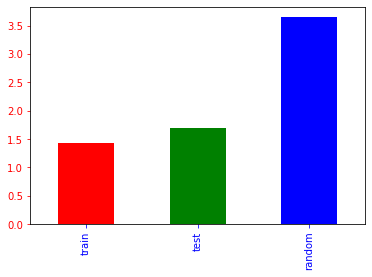

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


s = pd.Series(
    [dist_1,dist_2,dist_3],
    index = ["train", "test", "random"]
)

#Set descriptions:
# plt.title("Total Delay Incident Caused by Carrier")
# plt.ylabel('Delay Incident')
# plt.xlabel('Carrier')

#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='red')

#Plot the data:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']  #red, green, blue, black, etc.

s.plot( 
    kind='bar', 
    color=my_colors,
)

plt.show()

Hamming distanced were evaluated for three types of bit strings: bit strings taken from the training set, bit strings taken
from the test set, and randomly sampled bit strings.

For the randomly sampled bit strings, the average minimum Hamming distance to a differently
classified bit string is not close to the expected theoretical value(7.28) as was observed by the authors when they performed the analysis with the MNIST dataset.

Text(0.5, 1.0, 'Train')

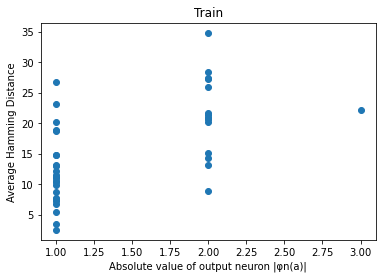

In [23]:
df_1 = df.loc[df['type_image'] == 'train']
plt.scatter(df_1['distance'],np.abs(df_1['phi_val']))
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")
plt.title("Train")

Text(0.5, 1.0, 'Random')

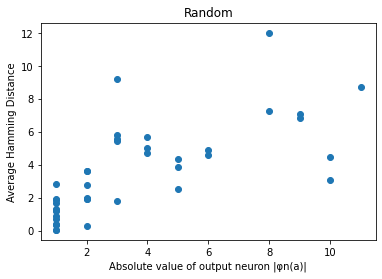

In [24]:
df_2 = df.loc[df['type_image'] == 'random']
plt.scatter(df_2['distance'],np.abs(df_2['phi_val']))
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")
plt.title("Random")

Text(0.5, 1.0, 'Test')

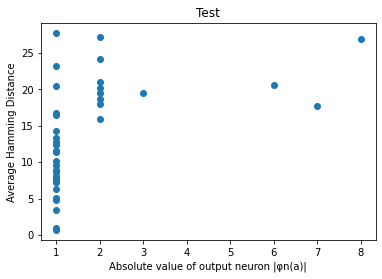

In [25]:
df_3 = df.loc[df['type_image'] == 'test']
plt.scatter(df_3['distance'],np.abs(df_3['phi_val']))
plt.xlabel("Absolute value of output neuron |φn(a)|")
plt.ylabel("Average Hamming Distance")
plt.title("Test")